In [2]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler
import joblib


In [3]:
Selected_features = ['Bathrooms_2.0', 'Square Feet', 'Rent_Benchmark_1_neighbors', 'Rent_Benchmark_5_neighbors', 'Rent_Benchmark_10_neighbors', 'median_income^2', 'median_income Bedrooms_2', 'median_income Bathrooms_1.5', 'median_income Square Feet', 'median_income Bedrooms', 'median_income Rent_Benchmark_1_neighbors', 'median_income Rent_Benchmark_5_neighbors', 'median_income Rent_Benchmark_10_neighbors', 'Bedrooms_2 Bathrooms_2.0', 'Bedrooms_2 Square Feet', 'Bedrooms_2 Rent_Benchmark_1_neighbors', 'Bedrooms_2 Rent_Benchmark_5_neighbors', 'Bedrooms_3 Bathrooms_2.0', 'Bedrooms_3 Square Feet', 'Bedrooms_3 Rent_Benchmark_1_neighbors', 'Bedrooms_3 Rent_Benchmark_10_neighbors', 'Bedrooms_4 Bathrooms_2.0', 'Bedrooms_4 Square Feet', 'Bedrooms_4 Rent_Benchmark_1_neighbors', 'Bedrooms_4 Rent_Benchmark_10_neighbors', 'Bedrooms_5 Bathrooms_2.0', 'Bedrooms_5 Square Feet', 'Bedrooms_5 Rent_Benchmark_1_neighbors', 'Bedrooms_5 Rent_Benchmark_5_neighbors', 'Bedrooms_5 Rent_Benchmark_10_neighbors', 'Bathrooms_1.5 Bedrooms', 'Bathrooms_1.5 Rent_Benchmark_1_neighbors', 'Bathrooms_1.5 Rent_Benchmark_10_neighbors', 'Bathrooms_2.0^2', 'Bathrooms_2.0 Square Feet', 'Bathrooms_2.0 Bedrooms', 'Bathrooms_2.0 Bathrooms', 'Bathrooms_2.0 Rent_Benchmark_1_neighbors', 'Bathrooms_2.0 Rent_Benchmark_5_neighbors', 'Bathrooms_2.0 Rent_Benchmark_10_neighbors', 'Bathrooms_2.5 Square Feet', 'Bathrooms_2.5 Rent_Benchmark_1_neighbors', 'Bathrooms_2.5 Rent_Benchmark_5_neighbors', 'Bathrooms_2.5 Rent_Benchmark_10_neighbors', 'Bathrooms_3.0 Rent_Benchmark_1_neighbors', 'Bathrooms_3.0 Rent_Benchmark_5_neighbors', 'Bathrooms_3.0 Rent_Benchmark_10_neighbors', 'Square Feet^2', 'Square Feet Bedrooms', 'Square Feet Bathrooms', 'Square Feet Rent_Benchmark_1_neighbors', 'Square Feet Rent_Benchmark_5_neighbors', 'Square Feet Rent_Benchmark_10_neighbors', 'Bedrooms Bathrooms', 'Bedrooms Rent_Benchmark_1_neighbors', 'Bedrooms Rent_Benchmark_5_neighbors', 'Bedrooms Rent_Benchmark_10_neighbors', 'Bathrooms Rent_Benchmark_1_neighbors', 'Rent_Benchmark_1_neighbors^2', 'Rent_Benchmark_1_neighbors Rent_Benchmark_5_neighbors', 'Rent_Benchmark_1_neighbors Rent_Benchmark_10_neighbors', 'Rent_Benchmark_5_neighbors^2', 'Rent_Benchmark_5_neighbors Rent_Benchmark_10_neighbors', 'Rent_Benchmark_10_neighbors^2']

In [47]:
states_trained = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals.csv")
states = states_trained["State_Code"].unique()

# Load the new data
df = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\for_sale_homes.csv", index_col=False)

# Apply initial filtering on the DataFrame
df = df[(df["Bedrooms"] >= 1) 
        & (df["Bedrooms"] < 6)  
        & (df["Bathrooms"] < 4)
        & (df["Bathrooms"] >= 1)  
        & (df["Square Feet"] < 5000)    
        & (df["State"].notna())]

df["Bedrooms"] = df["Bedrooms"].astype(str).str.split('.').str[0]

basic_features = ["Square Feet", "Bedrooms", "Bathrooms"]
basic_metadata = ['MLS ID', 'Status', 'Price', 'HOA Fee', 'Lot Size', 
       'Location', 'Stories', 'Address', 'City', 'State', 'ZIP Code',
       'Year Built', 'URL', 'Latitude', 'Longitude', 'updated_date']

#### Some sites are getting filtered out in this step. why (ists aprox 400)

In [48]:
#Get Median Income Data
median_income = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\ACSDT5Y2022.B19013-Data.csv", skiprows=[1], na_values='-')

median_income['GEO_ID'] = median_income['GEO_ID'].astype(str)

# Extracting everything after "US" and storing it in a new column 'cbg_geoid'
median_income['cbg_geoid'] = median_income['GEO_ID'].str.extract('US(\d+)')
median_income['median_income'] = median_income['B19013_001E'].str.replace(',','+').str.replace('+','').str.replace('-','').astype(float)

median_income = median_income[["cbg_geoid", "median_income" ]]


print(df["MLS ID"].count())

df["cbg_geoid"] = df["cbg_geoid"].astype(str).str.split('.').str[0]
median_income["cbg_geoid"] = median_income["cbg_geoid"].astype(str)

df = df.merge(median_income, on='cbg_geoid', how="inner")

print(df["MLS ID"].count())


32445
32382


In [49]:

# Filter out rows where the state is not in the trained states
filtered_df = df[df["State_Code"].isin(states)]
filtered_out_count = len(df) - len(filtered_df)

# Show the count of predictions filtered out
print(f"Number of rows filtered out: {filtered_out_count}")

# Proceed with the prediction for the remaining rows
knn_features = ["Latitude", "Longitude"]
n_values = [1, 5, 10]

# Convert latitude and longitude from degrees to radians for haversine metric
new_data_rad = np.radians(filtered_df[knn_features].values)

# Loop over different values of n and use the saved models to predict rent benchmarks
for n in n_values:
    column_name = f'Rent_Benchmark_{n}_neighbors'
    
    # Load the trained model
    knn = joblib.load(fr'Models\knn_model_{n}_neighbors.pkl')
    
    # Predict the average rent for each point in the new data
    filtered_df[column_name] = knn.predict(new_data_rad)

# Display the new data with the predicted rent benchmarks

df = filtered_df

benchmark_features = [f'Rent_Benchmark_{n}_neighbors' for n in n_values]


Number of rows filtered out: 0


In [50]:
columns_to_encode = ['Bedrooms', 'Bathrooms']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid dummy variable trap

# Fit and transform the data
encoded_features = encoder.fit_transform(df[columns_to_encode])

# Get feature names for the encoded columns
encoded_feature_names = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns = encoded_feature_names)

# Concatenate the original DataFrame (excluding the original columns) with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

one_hot_features = encoded_feature_names.tolist()

In [51]:
potential_features = ["median_income"] + one_hot_features + basic_features + benchmark_features


scale_df = df[potential_features].dropna() 
# display(clean_df)
# display(potential_features)

X = scale_df[potential_features]

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

In [52]:
poly = PolynomialFeatures(degree = 2, include_bias=False)

X_poly = poly.fit_transform(X_scaled)

print("X_pred_poly.shape: {}".format(X_poly.shape))

feature_names = poly.get_feature_names_out(potential_features)



X_pred_poly.shape: (31260, 209)


In [53]:
all_feature_df = pd.DataFrame(X_poly, index=scale_df.index, columns=feature_names)

selected_features_df = all_feature_df[Selected_features]


In [54]:
display(selected_features_df)



,Bathrooms_2.0,Square Feet,Rent_Benchmark_1_neighbors,Rent_Benchmark_5_neighbors,Rent_Benchmark_10_neighbors,median_income^2,median_income Bedrooms_2,median_income Bathrooms_1.5,median_income Square Feet,median_income Bedrooms,...,Bedrooms Rent_Benchmark_1_neighbors,Bedrooms Rent_Benchmark_5_neighbors,Bedrooms Rent_Benchmark_10_neighbors,Bathrooms Rent_Benchmark_1_neighbors,Rent_Benchmark_1_neighbors^2,Rent_Benchmark_1_neighbors Rent_Benchmark_5_neighbors,Rent_Benchmark_1_neighbors Rent_Benchmark_10_neighbors,Rent_Benchmark_5_neighbors^2,Rent_Benchmark_5_neighbors Rent_Benchmark_10_neighbors,Rent_Benchmark_10_neighbors^2
0,1.0,0.608940,0.340549,0.340491,0.393900,0.235097,0.000000,0.0,0.295255,0.363651,...,0.255412,0.255368,0.295425,0.136220,0.115974,0.115954,0.134142,0.115934,0.134119,0.155157
1,0.0,0.556825,0.340549,0.399347,0.349023,0.235097,0.000000,0.0,0.269987,0.363651,...,0.255412,0.299511,0.261767,0.204329,0.115974,0.135997,0.118859,0.159478,0.139381,0.121817
2,1.0,0.382441,0.340549,0.399347,0.349023,0.235097,0.000000,0.0,0.185434,0.363651,...,0.255412,0.299511,0.261767,0.136220,0.115974,0.135997,0.118859,0.159478,0.139381,0.121817
3,0.0,0.477851,0.340549,0.390752,0.350258,0.235097,0.000000,0.0,0.231695,0.363651,...,0.255412,0.293064,0.262693,0.272439,0.115974,0.133070,0.119280,0.152687,0.136864,0.122680
4,0.0,0.477851,0.340549,0.390752,0.350258,0.235097,0.000000,0.0,0.231695,0.363651,...,0.255412,0.293064,0.262693,0.272439,0.115974,0.133070,0.119280,0.152687,0.136864,0.122680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32377,1.0,0.569653,0.155755,0.261677,0.251742,0.027607,0.166154,0.0,0.094650,0.041539,...,0.038939,0.065419,0.062935,0.062302,0.024260,0.040757,0.039210,0.068475,0.065875,0.063374
32378,1.0,0.237723,0.155755,0.261677,0.246801,0.027607,0.000000,0.0,0.039499,0.083077,...,0.077878,0.130838,0.123400,0.062302,0.024260,0.040757,0.038440,0.068475,0.064582,0.060911
32379,1.0,0.301664,0.155755,0.261677,0.251742,0.027607,0.000000,0.0,0.050123,0.083077,...,0.077878,0.130838,0.125871,0.062302,0.024260,0.040757,0.039210,0.068475,0.065875,0.063374
32380,0.0,0.506915,0.155755,0.261677,0.246801,0.027607,0.000000,0.0,0.084226,0.083077,...,0.077878,0.130838,0.123400,0.093453,0.024260,0.040757,0.038440,0.068475,0.064582,0.060911


In [55]:
reg = joblib.load(fr'Models\single_family_rent_predictor.joblib')

rent_pred = reg.predict(selected_features_df)


In [56]:
scale_df["predicted_rent"] = rent_pred

selected_features_df["predicted_rent"] = rent_pred

C:\Users\mattl\AppData\Local\Temp\ipykernel_19488\3062058877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_df["predicted_rent"] = rent_pred


<Axes: xlabel='predicted_rent', ylabel='Count'>

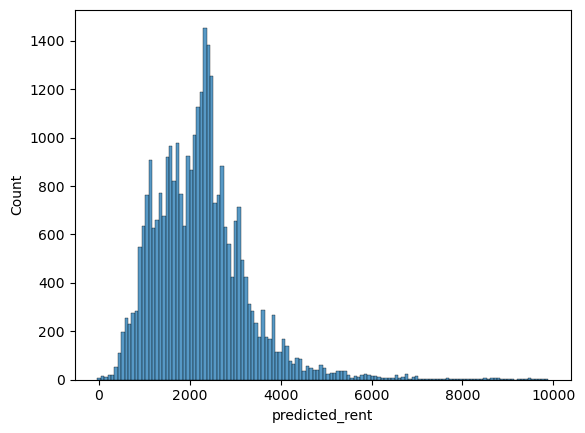

In [58]:
sns.histplot(scale_df["predicted_rent"])